In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=10,6

In [2]:
dataset=pd.read_excel(r"C:\Users\Ramana Reddy (Rakhi)\OneDrive\Desktop\crypto project\etheram.xlsx")
dataset

,ticker,date,open,high,low,close
0,ETC,2017-01-01,1.4500,1.5000,1.3300,1.4000
1,ETC,2017-01-02,1.4000,1.4500,1.3500,1.4300
2,ETC,2017-01-03,1.4300,1.5700,1.4000,1.4800
3,ETC,2017-01-04,1.4800,1.7600,1.4300,1.7400
4,ETC,2017-01-05,1.7400,1.8500,1.4000,1.5900
...,...,...,...,...,...,...
2739,ETC,2024-07-02,23.3591,23.4377,22.9409,23.2100
2740,ETC,2024-07-03,23.2182,23.3033,22.2471,22.5327
2741,ETC,2024-07-04,22.5305,22.6074,21.0963,21.5259
2742,ETC,2024-07-05,21.5117,21.6096,18.1624,20.2116


In [3]:
dataset['date']=pd.to_datetime(dataset['date'],infer_datetime_format=True)
indexedDataset= dataset.set_index(['date'])

In [4]:
indexedDataset=indexedDataset.drop(columns=['ticker','high','low','open'])
indexedDataset=indexedDataset.resample('M').mean()
indexedDataset.head()

,close
date,
2017-01-31,1.350645
2017-02-28,1.277500
2017-03-31,1.836129
2017-04-30,3.281000
2017-05-31,9.241613


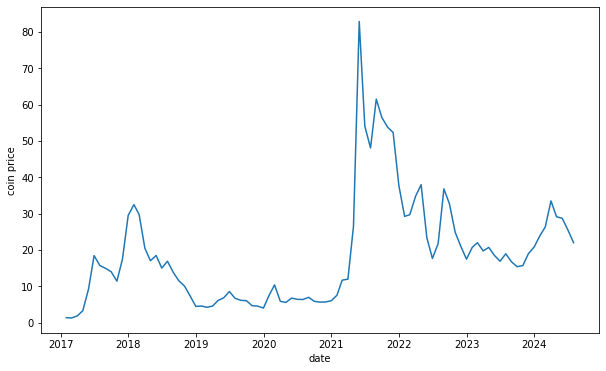

In [5]:
plt.xlabel('date')
plt.ylabel('coin price')
plt.plot(indexedDataset)

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #determing rolling statistics
    moving_avg=timeseries.rolling(window=12).mean()
    moving_std = timeseries.rolling(window=12).std()
    
    #plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(moving_avg,color='red',label='rolling mean' )
    std=plt.plot(moving_std,color='black',label='rolling std')
    plt.legend(loc='best')
    plt.show(block=False)
    #perform Dickey fuller test;
    print("results of Dickey-fuller test:")
    dftest=adfuller(timeseries['close'],autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test statistic','p-value','lags used','number of Observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key]=value
    print(dfoutput)

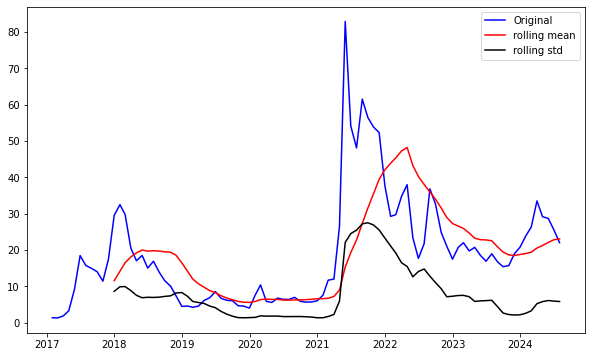

results of Dickey-fuller test:
Test statistic                 -2.790337
p-value                         0.059667
lags used                       0.000000
number of Observations used    90.000000
Critical value (1%)            -3.505190
Critical value (5%)            -2.894232
Critical value (10%)           -2.584210
dtype: float64


In [7]:
test_stationarity(indexedDataset)

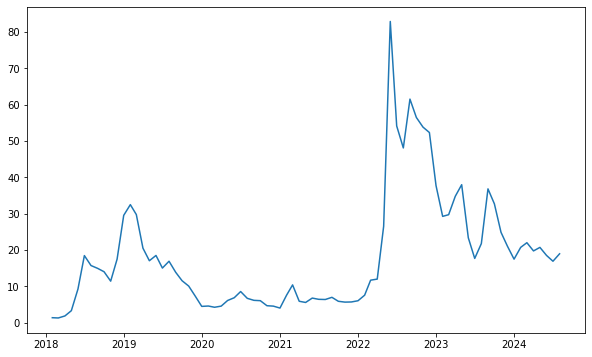

In [8]:
#estimating trend
indexedDataset_shift=indexedDataset.shift(12).dropna()
plt.plot(indexedDataset_shift)

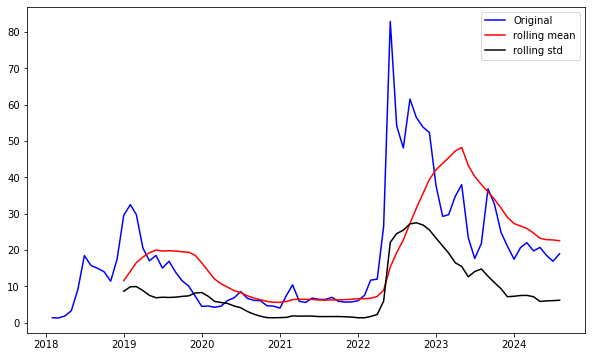

results of Dickey-fuller test:
Test statistic                 -2.601308
p-value                         0.092727
lags used                       0.000000
number of Observations used    78.000000
Critical value (1%)            -3.517114
Critical value (5%)            -2.899375
Critical value (10%)           -2.586955
dtype: float64


In [9]:
test_stationarity(indexedDataset_shift)

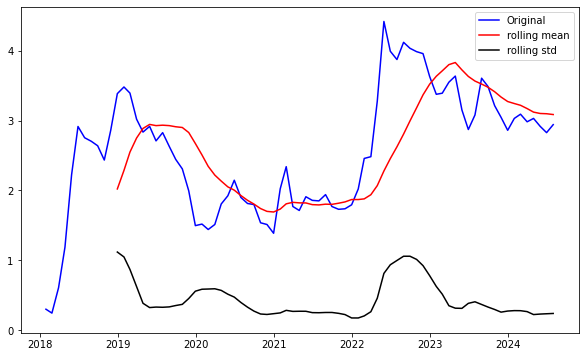

results of Dickey-fuller test:
Test statistic                 -1.776746
p-value                         0.392066
lags used                       5.000000
number of Observations used    73.000000
Critical value (1%)            -3.523284
Critical value (5%)            -2.902031
Critical value (10%)           -2.588371
dtype: float64


In [10]:
indexedDataset_logscale=np.log(indexedDataset_shift)
test_stationarity(indexedDataset_logscale)

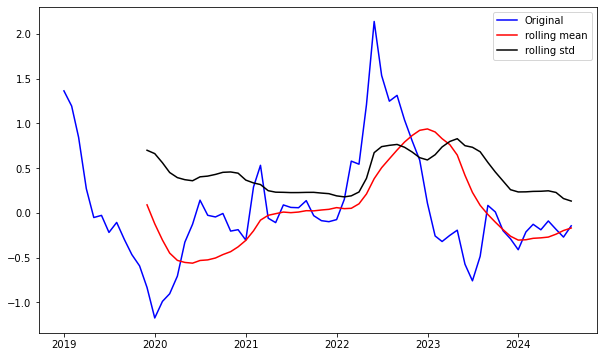

results of Dickey-fuller test:
Test statistic                 -2.727939
p-value                         0.069327
lags used                       3.000000
number of Observations used    64.000000
Critical value (1%)            -3.536928
Critical value (5%)            -2.907887
Critical value (10%)           -2.591493
dtype: float64


In [11]:
moving_avg=indexedDataset_logscale.rolling(window=12).mean()
datasetlogscale_moving_avg=indexedDataset_logscale-moving_avg
datasetlogscale_moving_avg.head(12)
#remove nan values
datasetlogscale_moving_avg.dropna(inplace=True)
test_stationarity(datasetlogscale_moving_avg)

# Seasonal Decompose

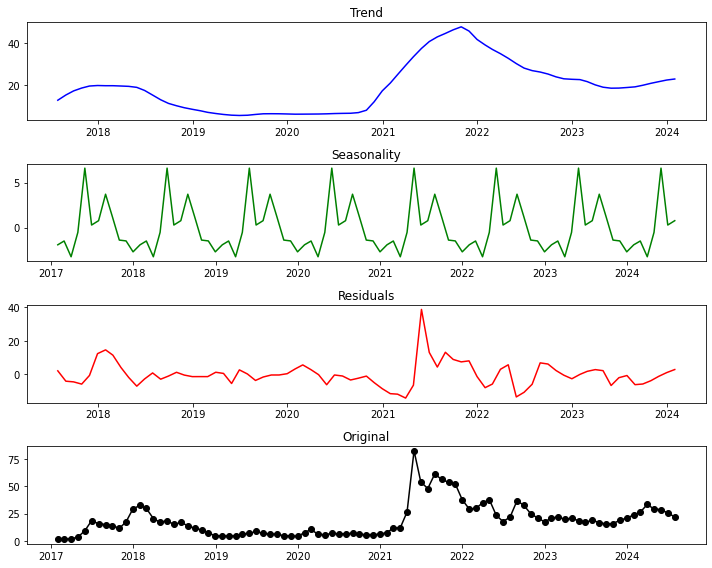

In [12]:
decomposition = seasonal_decompose(indexedDataset, model='additive')
plt.figure(figsize=(10,8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.title('Trend')

plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonality')

plt.subplot(4, 1, 3)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Residuals')

plt.subplot(4, 1, 4)
plt.plot(indexedDataset.index, indexedDataset.values, marker='o', linestyle='-', label='Original', color='black')
plt.title('Original')

plt.tight_layout()
plt.show()

# AUTO CORRELATION AND PARTIAL AUTOCORRELATION graphs

C:\Users\Ramana Reddy (Rakhi)\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


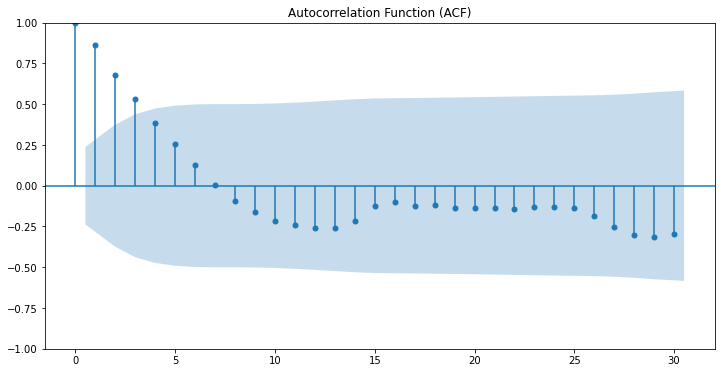

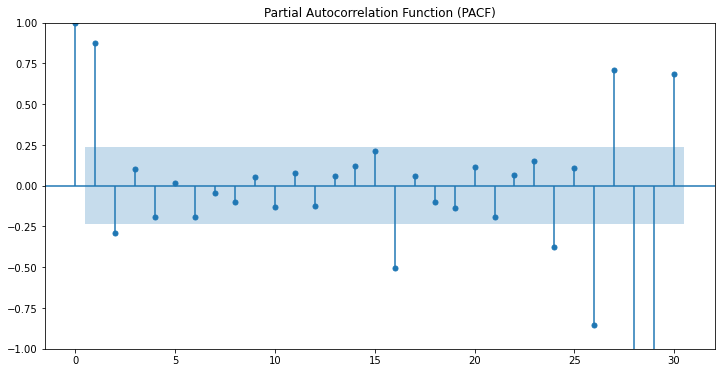

In [13]:
import statsmodels.api as sm

# Plot ACF
fig, ax1 = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(datasetlogscale_moving_avg['close'], lags=30, ax=ax1)
plt.title('Autocorrelation Function (ACF)')

# Plot PACF
fig, ax2 = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(datasetlogscale_moving_avg['close'], lags=30, ax=ax2)
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

In [14]:
# Split data into train and test sets
X = np.arange(len(indexedDataset)).reshape(-1, 1)
y = indexedDataset.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(72, 1)
(72, 1)
(19, 1)
(19, 1)


C:\Users\Ramana Reddy (Rakhi)\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:                 ARIMA(3, 0, 9)   Log Likelihood                -254.721
Date:                Fri, 23 Aug 2024   AIC                            537.441
Time:                        21:52:06   BIC                            569.315
Sample:                             0   HQIC                           550.130
                                 - 72                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.1538      9.433      1.924      0.054      -0.335      36.643
ar.L1          1.2026      0.839      1.434      0.152      -0.441       2.846
ar.L2         -0.9392      0.986     -0.953      0.341      -2.871       0.993
ar.L3          0.6993      0.601      1.163      0.245      -0.479       1.878
ma.L1         -0.3242      1.026     -0.316      0.752      -2.335       1.686
ma.L2          0.5556      1.098      0.506      0.613      -1.597       2.708
ma.L3          0.0498      0.708      0.070      0.944      -1.337       1.437
ma.L4         -0.3350      0.738     -0.454      0.650      -1.781       1.110
ma.L5         -0.0862      0.605     -0.143      0.887      -1.271       1.099
ma.L6         -0.0846      0.691     -0.122      0.903      -1.439       1.269
ma.L7         -0.3214      0.678     -0.474      0.636      -1.651       1.008
ma.L8         -0.1762      0.579     -0.304      0.761      -1.310       0.958
ma.L9         -0.2350      0.435     -0.540      0.589      -1.088       0.618
sigma2        65.7090     36.289      1.811      0.070      -5.416     136.834
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1997.27
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               6.26   Skew:                             3.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

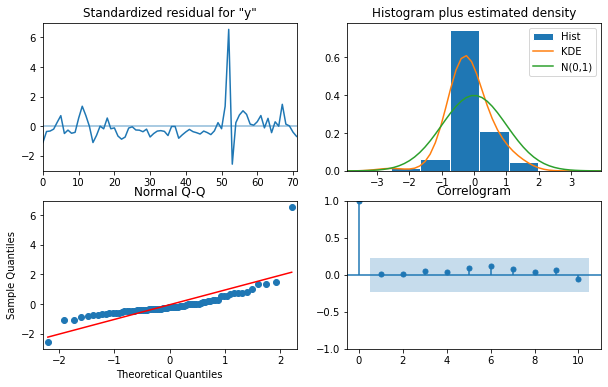

In [39]:
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit ARIMA model
arima_model = ARIMA(y_train,order=(3,0,9))
pred_arima = arima_model.fit()
predicion=pred_arima.plot_diagnostics()
pred_arima.summary()

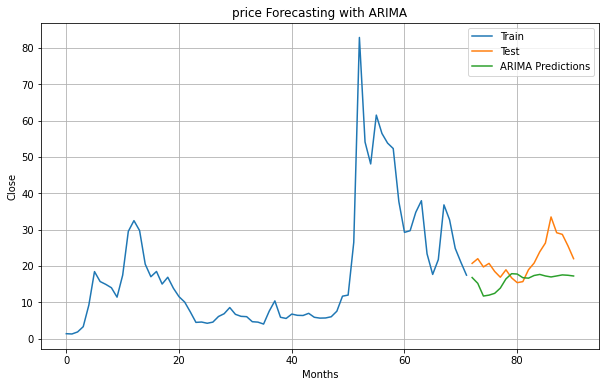

In [40]:
arima_predictions =pred_arima.forecast(steps=len(X_test))
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, label='Train')
plt.plot(X_test, y_test, label='Test')
plt.plot(X_test, arima_predictions, label='ARIMA Predictions')
plt.title('price Forecasting with ARIMA')
plt.xlabel('Months')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
index_future_date=pd.date_range(start='2024-06-30',end='2024-09-25')
print(index_future_date)
pred=pred_arima.predict(start=len(indexedDataset),end=len(indexedDataset)+50,typ='levels')
#print(comp_pred)
predindex=index_future_date
dataframe=pd.DataFrame(pred)
dataframe.head(10)

DatetimeIndex(['2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
               '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07',
               '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-15',
               '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19',
               '2024-07-20', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27',
               '2024-07-28', '2024-07-29', '2024-07-30', '2024-07-31',
               '2024-08-01', '2024-08-02', '2024-08-03', '2024-08-04',
               '2024-08-05', '2024-08-06', '2024-08-07', '2024-08-08',
               '2024-08-09', '2024-08-10', '2024-08-11', '2024-08-12',
               '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16',
               '2024-08-17', '2024-08-18', '2024-08-19', '2024-08-20',
               '2024-08-21', '2024-08-22', '2024-08-23', '2024-08-24',
      

,0
0,17.284144
1,17.469801
2,17.500201
3,17.401993
4,17.385172
5,17.478437
6,17.537719
7,17.509654
8,17.485449
9,17.524156


<AxesSubplot:>

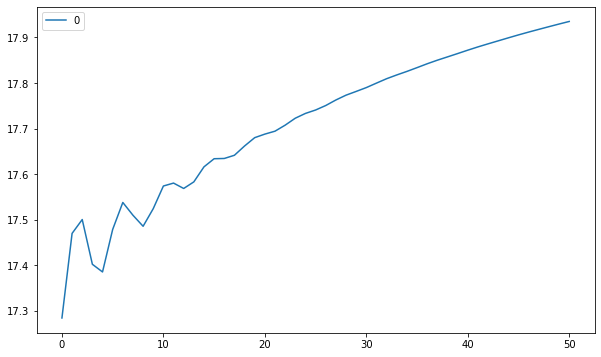

In [42]:
dataframe.plot()

In [38]:
print(mean_absolute_error(y_test,arima_predictions))
print(mean_squared_error(y_test,arima_predictions))
print(r2_score(y_test,arima_predictions))

5.146760085916886
45.551105396821896
-0.9696609198105162
